# NIPS Tutorial

# Deep GP supervised learning

### Zhenwen Dai and Neil D. Lawrence

### Monday, 3rd December 2017

This notebook depends on [GPy](https://github.com/SheffieldML/GPy) and [PyDeepGP](https://github.com/SheffieldML/PyDeepGP). These libraries can be installed via pip:
```
pip install GPy
pip install git+https://github.com/SheffieldML/PyDeepGP.git
```

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display

import GPy

import deepgp

import mlai
import teaching_plots as plot 
from gp_tutorial import ax_default, meanplot, gpplot

### Olympic Marathon Data

The first thing we will do is load a standard data set for regression modelling. The data consists of the pace of Olympic Gold Medal Marathon winners for the Olympics from 1896 to present. First we load in the data and plot.

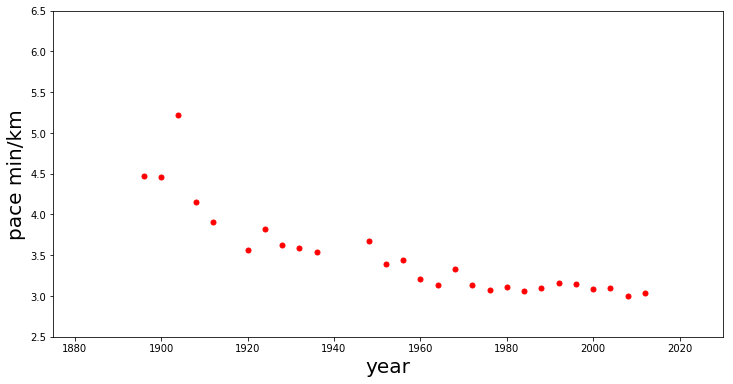

In [2]:
data = GPy.util.datasets.olympic_marathon_men()
x = data['X']
y = data['Y']

offset = y.mean()
scale = np.sqrt(y.var())

xlim = (1875,2030)
ylim = (2.5, 6.5)
yhat = (y-offset)/scale

fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
_ = ax.plot(x, y, 'r.',markersize=10)
ax.set_xlabel('year', fontsize=20)
ax.set_ylabel('pace min/km', fontsize=20)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

mlai.write_figure(figure=fig, filename='../../slides/diagrams/datasets/olympic-marathon.svg', transparent=True, frameon=True)


Things to notice about the data include the outlier in 1904, in this year, the olympics was in St Louis, USA. Organizational problems and challenges with dust kicked up by the cars following the race meant that participants got lost, and only very few participants completed. 

More recent years see more consistently quick marathons.

Our first objective will be to perform a Gaussian process fit to the data, we'll do this using the [GPy software](https://github.com/SheffieldML/GPy). 

In [3]:
m_full = GPy.models.GPRegression(x,yhat)
_ = m_full.optimize() # Optimize parameters of covariance function


The first command sets up the model, then 
```
m_full.optimize()
```
optimizes the parameters of the covariance function and the noise level of the model. Once the fit is complete, we'll try creating some test points, and computing the output of the GP model in terms of the mean and standard deviation of the posterior functions between 1870 and 2030. We plot the mean function and the standard deviation at 200 locations. We can obtain the predictions using
```
y_mean, y_var = m_full.predict(xt)
```

In [4]:
xt = np.linspace(1870,2030,200)[:,np.newaxis]
yt_mean, yt_var = m_full.predict(xt)
yt_sd=np.sqrt(yt_var)

Now we plot the results using the helper function ```gpplot```. 

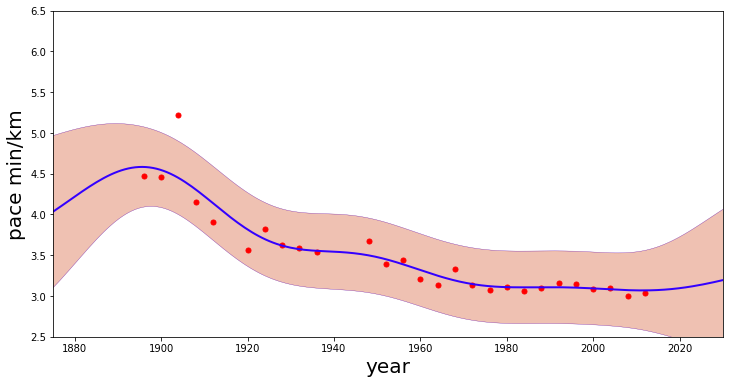

In [5]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
def plot_model_output(model, output_dim=0, scale=1.0, offset=0.0, ax=None, xlabel='$x$', ylabel='$y$', fontsize=20, portion=0.2):
    if ax is None:
        fig, ax = plt.subplots(figsize=plot.big_figsize)
    ax.plot(model.X.flatten(), model.Y[:, output_dim]*scale + offset, 'r.',markersize=10)
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    xt = plot.pred_range(model.X, portion=portion)
    yt_mean, yt_var = model.predict(xt)
    yt_mean = yt_mean*scale + offset
    yt_var *= scale*scale
    yt_sd=np.sqrt(yt_var)
    if yt_sd.shape[1]>1:
        yt_sd = yt_sd[:, output_dim]

    _ = gpplot(xt.flatten(),
               yt_mean[:, output_dim],
               yt_mean[:, output_dim]-2*yt_sd.flatten(),
               yt_mean[:, output_dim]+2*yt_sd.flatten(), 
               ax=ax)

plot_model_output(m_full, scale=scale, offset=offset, ax=ax, xlabel='year', ylabel='pace min/km', fontsize=20, portion=0.2)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
mlai.write_figure(figure=fig,
                  filename='../../slides/diagrams/gp/olympic-marathon-gp.svg', 
                  transparent=True, frameon=True)

### Fit Quality

In the fit we see that the error bars (coming mainly from the noise variance) are quite large. This is likely due to the outlier point in 1904, ignoring that point we can see that a tighter fit is obtained. To see this making a version of the model, ```m_clean```, where that point is removed. 

```
x_clean=np.vstack((x[0:2, :], x[3:, :]))
y_clean=np.vstack((y[0:2, :], y[3:, :]))

m_clean = GPy.models.GPRegression(x_clean,y_clean)
_ = m_clean.optimize()
```


### Deep GP Fit

Let's see if a deep Gaussian process can help here. We will construct a deep Gaussian process with one hidden layer (i.e. one Gaussian process feeding into another). 

Build a Deep GP with an additional hidden layer (one dimensional) to fit the model.

In [6]:
hidden = 1
m = deepgp.DeepGP([y.shape[1],hidden,x.shape[1]],Y=yhat, X=x, inits=['PCA','PCA'], 
                  kernels=[GPy.kern.RBF(hidden,ARD=True),
                           GPy.kern.RBF(x.shape[1],ARD=True)], # the kernels for each layer
                  num_inducing=50, back_constraint=False)

Deep Gaussian process models also can require some thought in initialization. Here we choose to start by setting the noise variance to be one percent of the data variance.

Optimization requires moving variational parameters in the hidden layer representing the mean and variance of the expected values in that layer. Since all those values can be scaled up, and this only results in a downscaling in the output of the first GP, and a downscaling of the input length scale to the second GP. It makes sense to first of all fix the scales of the covariance function in each of the GPs.

Sometimes, deep Gaussian processes can find a local minima which involves increasing the noise level of one or more of the GPs. This often occurs because it allows a minimum in the KL divergence term in the lower bound on the likelihood. To avoid this minimum we habitually train with the likelihood variance (the noise on the output of the GP) fixed to some lower value for some iterations.

Let's create a helper function to initialize the models we use in the notebook.

In [7]:
def initialize(self, noise_factor=0.01, linear_factor=1):
    """Helper function for deep model initialization."""
    self.obslayer.likelihood.variance = self.Y.var()*noise_factor
    for layer in self.layers:
        if type(layer.X) is GPy.core.parameterization.variational.NormalPosterior:
            var = layer.X.mean.var(0)
        else:
            var = layer.X.var(0)*linear_factor*linear_factor
        # Average 0.5 upcrossings in four standard deviations. 
        layer.kern.lengthscale = linear_factor*np.sqrt(layer.kern.input_dim)*2*4*np.sqrt(var)/(2*np.pi)
# Bind the new method to the Deep GP object.
deepgp.DeepGP.initialize=initialize

# Call the initalization
m.initialize()

Now optimize the model. The first stage of optimization is working on variational parameters and lengthscales only. 
```
m.optimize(messages=False,max_iters=100)
```

Now we remove the constraints on the scale of the covariance functions associated with each GP and optimize again.
```
for layer in m.layers:
    pass #layer.kern.variance.constrain_positive(warning=False)
m.obslayer.kern.variance.constrain_positive(warning=False)
m.optimize(messages=False,max_iters=100)
```

Finally, we allow the noise variance to change and optimize for a large number of iterations.
```
for layer in m.layers:
    layer.likelihood.variance.constrain_positive(warning=False)
m.optimize(messages=True,max_iters=10000)
```

For our optimization process we define a new function.

In [8]:
def staged_optimize(self, iters=(1000,1000,10000), messages=(False, False, True)):
    """Optimize with parameters constrained and then with parameters released"""
    for layer in self.layers:
        # Fix the scale of each of the covariance functions.
        layer.kern.variance.fix(warning=False)
        layer.kern.lengthscale.fix(warning=False)

        # Fix the variance of the noise in each layer.
        layer.likelihood.variance.fix(warning=False)

    self.optimize(messages=messages[0],max_iters=iters[0])
    
    for layer in self.layers:
        layer.kern.lengthscale.constrain_positive(warning=False)
    self.obslayer.kern.variance.constrain_positive(warning=False)


    self.optimize(messages=messages[1],max_iters=iters[1])

    for layer in self.layers:
        layer.kern.variance.constrain_positive(warning=False)
        layer.likelihood.variance.constrain_positive(warning=False)
    self.optimize(messages=messages[2],max_iters=iters[2])
    
# Bind the new method to the Deep GP object.
deepgp.DeepGP.staged_optimize=staged_optimize

In [9]:
m.staged_optimize(messages=(True,True,True))

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s10  0002   8.765225e+01   1.014021e+04 
    00s16  0005   6.810863e+01   1.621110e+02 
    01s16  0100   3.431800e+01   1.947134e+00 
    05s19  0448   3.402651e+01   1.778752e-02 
    06s19  0541   3.400924e+01   1.336258e-02 
    09s21  0823   3.400216e+01   4.247847e-03 
    09s87  0875   3.400203e+01   1.196412e-04 
Runtime:     09s87
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s18  0009   2.784323e+01   8.532436e+01 
    00s19  0010   2.779500e+01   3.073620e+02 
    03s22  0269   2.297867e+01   1.357694e+00 
    07s96  0664   2.051438e+01   1.229080e-02 
Runtime:     07s96
Optimization status: Errorb'ABNORMAL_TERMINATION_IN_LNSRCH'

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i       f              |g|        
    00s04  00002   3.160795e+01   2.422887e+04 
    00s19  00009   2.048496

### Plot the prediction

The prediction of the deep GP can be extracted in a similar way to the normal GP. Although, in this case, it is an approximation to the true distribution, because the true distribution is not Gaussian. 

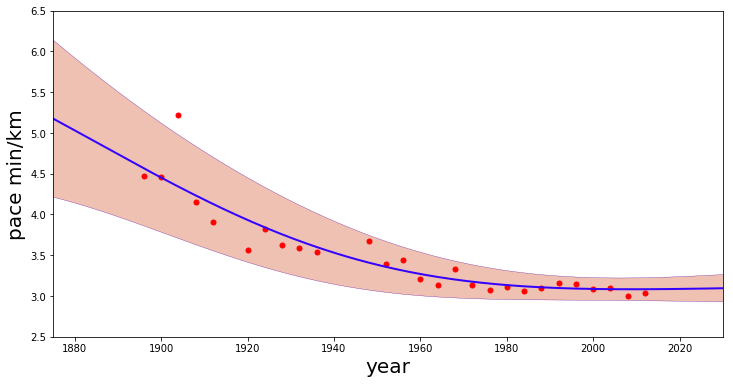

In [10]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
plot_model_output(m, scale=scale, offset=offset, ax=ax, xlabel='year', ylabel='pace min/km', 
          fontsize=20, portion=0.2)
ax.set_xlim(xlim)

ax.set_ylim(ylim)
mlai.write_figure(figure=fig, filename='../../slides/diagrams/deepgp/olympic-marathon-deep-gp.svg', 
                transparent=True, frameon=True)

### Fitted GP for each layer

Now we explore the GPs the model has used to fit each layer. First of all, we look at the hidden layer.

In [11]:
def visualize(self, scale=1.0, offset=0.0, xlabel='input', ylabel='output', 
              xlim=None, ylim=None, fontsize=20, portion=0.2,dataset=None, diagrams='../diagrams'):
    """Visualize the layers in a deep GP with one-d input and output."""
    depth = len(self.layers)
    if dataset is None:
        fname = 'deep-gp-layer'
    else:
        fname = dataset + '-deep-gp-layer'
    filename = os.path.join(diagrams, fname)
    last_name = xlabel
    last_x = self.X
    for i, layer in enumerate(reversed(self.layers)):
        if i>0:
            plt.plot(last_x, layer.X.mean, 'r.',markersize=10)
            last_x=layer.X.mean
            ax=plt.gca()
            name = 'layer ' + str(i)
            plt.xlabel(last_name, fontsize=fontsize)
            plt.ylabel(name, fontsize=fontsize)
            last_name=name
            mlai.write_figure(filename=filename + '-' + str(i-1) + '.svg', 
                              transparent=True, frameon=True)
            
        if i==0 and xlim is not None:
            xt = plot.pred_range(np.array(xlim), portion=0.0)
        elif i>0:
            xt = plot.pred_range(np.array(next_lim), portion=0.0)
        else:
            xt = plot.pred_range(last_x, portion=portion)
        yt_mean, yt_var = layer.predict(xt)
        if layer==self.obslayer:
            yt_mean = yt_mean*scale + offset
            yt_var *= scale*scale
        yt_sd = np.sqrt(yt_var)
        gpplot(xt,yt_mean,yt_mean-2*yt_sd,yt_mean+2*yt_sd)
        ax = plt.gca()
        if i>0:
            ax.set_xlim(next_lim)
        elif xlim is not None:
            ax.set_xlim(xlim)
        next_lim = plt.gca().get_ylim()
        
    plt.plot(last_x, self.Y*scale + offset, 'r.',markersize=10)
    plt.xlabel(last_name, fontsize=fontsize)
    plt.ylabel(ylabel, fontsize=fontsize)
    mlai.write_figure(filename=filename + '-' + str(i) + '.svg', 
                      transparent=True, frameon=True)

    if ylim is not None:
        ax=plt.gca()
        ax.set_ylim(ylim)

# Bind the new method to the Deep GP object.
deepgp.DeepGP.visualize=visualize


In [12]:
def posterior_sample(self, X, **kwargs):
    """Give a sample from the posterior of the deep GP."""
    Z = X
    for i, layer in enumerate(reversed(self.layers)):
        Z = layer.posterior_samples(Z, size=1, **kwargs)[:, :, 0]
 
    return Z
deepgp.DeepGP.posterior_sample = posterior_sample


 /Users/neil/anaconda3/lib/python3.6/site-packages/GPy/core/gp.py:557: RuntimeWarning:covariance is not positive-semidefinite.


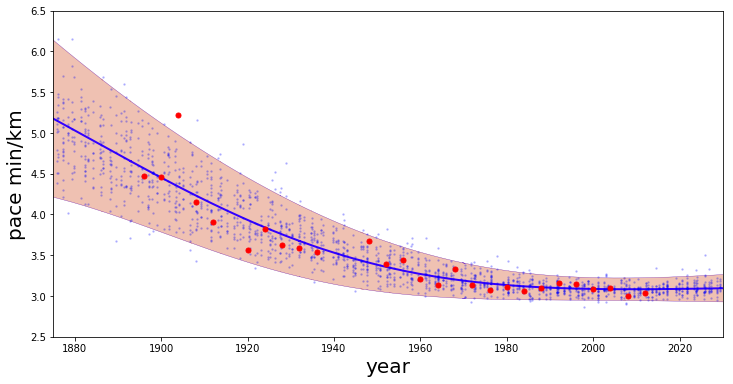

In [13]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
def plot_model_sample(model, output_dim=0, scale=1.0, offset=0.0, samps=10, ax=None, xlabel='$x$', ylabel='$y$', 
                      fontsize=20, portion=0.2):
    if ax is None:
        fig, ax = plt.subplots(figsize=plot.big_figsize)
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    
    xt = plot.pred_range(model.X, portion=portion)
    xt = xt + np.random.randn(*xt.shape)*0.5*(xt[:-1,:]-xt[1:,:]).mean()
    yt_mean, yt_var = model.predict(xt)
    yt_mean = yt_mean*scale + offset
    yt_var *= scale*scale
    yt_sd=np.sqrt(yt_var)
    if yt_sd.shape[1]>1:
        yt_sd = yt_sd[:, output_dim]
        
    _ = gpplot(xt.flatten(),
               yt_mean[:, output_dim],
               yt_mean[:, output_dim]-2*yt_sd.flatten(),
               yt_mean[:, output_dim]+2*yt_sd.flatten(), 
               ax=ax)
    for i in range(samps):
        a = model.posterior_sample(xt)
        ax.plot(xt.flatten(), a[:, output_dim]*scale+offset, 'b.',markersize=3, alpha=0.2)
    ax.plot(model.X.flatten(), model.Y[:, output_dim]*scale+offset, 'r.',markersize=10)

plot_model_sample(m, scale=scale, offset=offset, samps=10, ax=ax, 
                  xlabel='year', ylabel='pace min/km', portion = 0.225)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
mlai.write_figure(figure=fig, filename='../../slides/diagrams/deepgp/olympic-marathon-deep-gp-sample.svg', 
                  transparent=True, frameon=True)


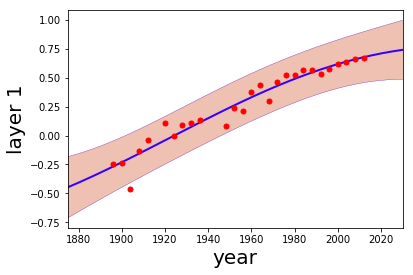

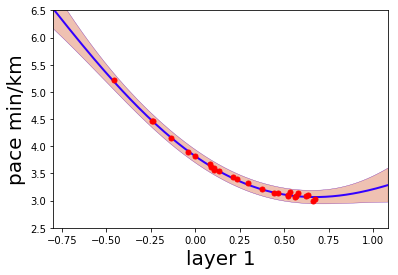

In [14]:
m.visualize(scale=scale, offset=offset, xlabel='year',
            ylabel='pace min/km',xlim=xlim, ylim=ylim,
            dataset='olympic-marathon',
            diagrams='../../slides/diagrams/deepgp')

### Motorcycle Crash Data

In [15]:
import pods
data = pods.datasets.mcycle()
x = data['X']
y = data['Y']
scale=np.sqrt(y.var())
offset=y.mean()
yhat = (y - offset)/scale


### Fit a GP Model

In [16]:
m_full = GPy.models.GPRegression(x,yhat)
_ = m_full.optimize() # Optimize parameters of covariance function


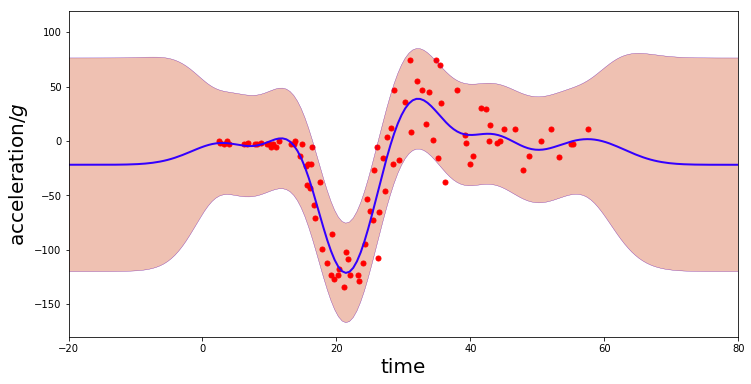

In [17]:
fig, ax=plt.subplots(figsize=plot.big_wide_figsize)
plot_model_output(m_full, scale=scale, offset=offset, ax=ax, xlabel='time', ylabel='acceleration/$g$', fontsize=20, portion=0.5)
xlim=(-20,80)
ylim=(-180,120)
ax.set_ylim(ylim)
ax.set_xlim(xlim)
mlai.write_figure(figure=fig,filename='../../slides/diagrams/gp/motorcycle-helmet-gp.svg', 
            transparent=True, frameon=True)

In [18]:
ylim

(-180, 120)

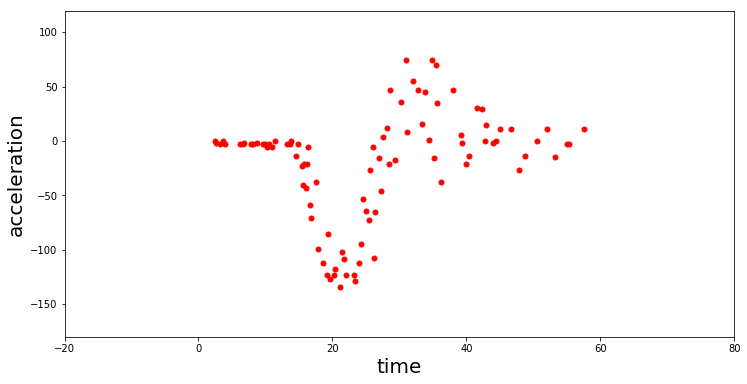

In [19]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
_ = ax.plot(x, y, 'r.',markersize=10)
_ = ax.set_xlabel('time', fontsize=20)
_ = ax.set_ylabel('acceleration', fontsize=20)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
mlai.write_figure(filename='../../slides/diagrams/datasets/motorcycle-helmet.svg', 
            transparent=True, frameon=True)

In [20]:
layers = [y.shape[1], 1, x.shape[1]]
inits = ['PCA']*(len(layers)-1)
kernels = []
for i in layers[1:]:
    kernels += [GPy.kern.RBF(i)]
m = deepgp.DeepGP(layers,Y=yhat, X=x, 
                  inits=inits, 
                  kernels=kernels, # the kernels for each layer
                  num_inducing=20, back_constraint=False)



m.initialize()

In [21]:
#for layer in m.layers:
#    layer.likelihood.variance=0.001
#    layer.kern.lengthscale = layer.kern.lengthscale/3
#m.layers[-1].lengthscale = 5
    

In [22]:
m.staged_optimize(iters=(1000,1000,10000), messages=(True, True, True))

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0000   2.301104e+03           nan 
    00s14  0004   7.553973e+02   5.827422e+04 
    00s19  0006   5.710493e+02   1.422575e+04 
    01s20  0110   2.486958e+02   2.041258e+02 
    02s20  0224   2.461218e+02   2.558474e+01 
    08s25  0661   2.450204e+02   4.740447e-01 
    11s26  0944   2.449860e+02   2.449839e-02 
    11s78  1002   2.449827e+02   3.125771e-03 
Runtime:     11s78
Optimization status: Maximum number of f evaluations reached

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0000   2.449827e+02   3.125771e-03 
    00s06  0003   2.042255e+02   4.023804e+03 
    00s19  0010   1.746876e+02   1.155161e+03 
    02s20  0228   8.686204e+01   1.873060e+02 
    03s21  0343   8.590255e+01   1.181479e+01 
    09s03  1002   8.563504e+01   3.082776e-01 
Runtime:     09s03
Optimization status: Maximum number of f evaluations reache

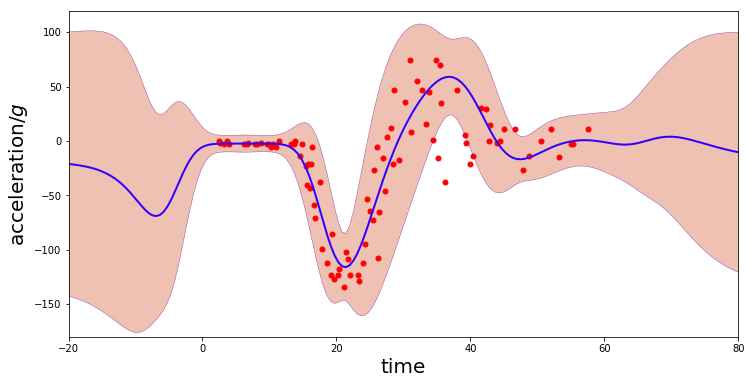

In [23]:
fig, ax=plt.subplots(figsize=plot.big_wide_figsize)
plot_model_output(m, scale=scale, offset=offset, ax=ax, xlabel='time', ylabel='acceleration/$g$', fontsize=20, portion=0.5)
ax.set_ylim(ylim)
ax.set_xlim(xlim)
mlai.write_figure(filename='../../slides/diagrams/deepgp/motorcycle-helmet-deep-gp.svg', 
            transparent=True, frameon=True)

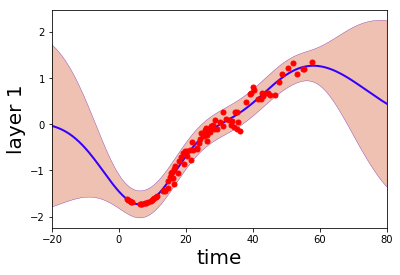

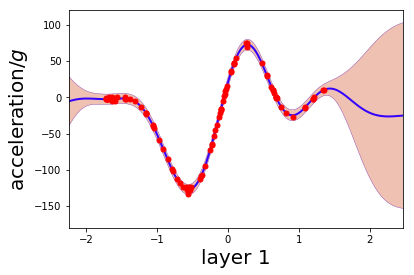

In [24]:
m.visualize(xlim=xlim, ylim=ylim, scale=scale,offset=offset, 
            xlabel="time", ylabel="acceleration/$g$", portion=0.5,
            dataset='motorcycle-helmet',
            diagrams='../../slides/diagrams/deepgp')

 /Users/neil/anaconda3/lib/python3.6/site-packages/GPy/core/gp.py:557: RuntimeWarning:covariance is not positive-semidefinite.


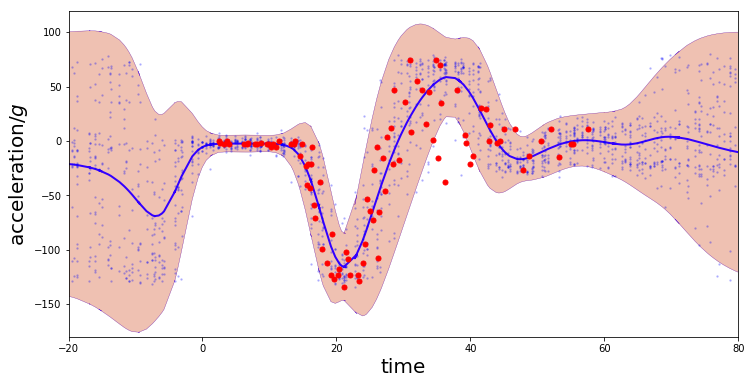

In [25]:
fig, ax=plt.subplots(figsize=plot.big_wide_figsize)
plot_model_sample(m, scale=scale, offset=offset, samps=10, ax=ax, xlabel='time', ylabel='acceleration/$g$', portion = 0.5)
ax.set_ylim(ylim)
ax.set_xlim(xlim)

mlai.write_figure(figure=fig, filename='../../slides/diagrams/deepgp/motorcycle-helmet-deep-gp-samples.svg', 
                  transparent=True, frameon=True)

### Robot Wireless Data

The robot wireless data is taken from an experiment run by Brian Ferris at University of Washington. It consists of the measurements of WiFi access point signal strengths as Brian walked in a loop.

In [26]:
data=pods.datasets.robot_wireless()

x = np.linspace(0,1,215)[:, np.newaxis]
y = data['Y']
offset = y.mean()
scale = np.sqrt(y.var())
yhat = (y-offset)/scale

The ground truth is recorded in the data, the actual loop is given in the plot below.

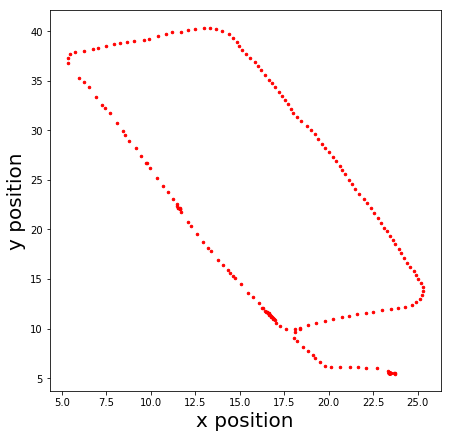

In [27]:
fig, ax = plt.subplots(figsize=plot.big_figsize)
plt.plot(data['X'][:, 1], data['X'][:, 2], 'r.', markersize=5)
ax.set_xlabel('x position', fontsize=20)
ax.set_ylabel('y position', fontsize=20)
mlai.write_figure(figure=fig, filename='../../slides/diagrams/datasets/robot-wireless-ground-truth.svg', transparent=True, frameon=True)

We will ignore this ground truth in making our predictions, but see if the model can recover something similar in one of the latent layers.

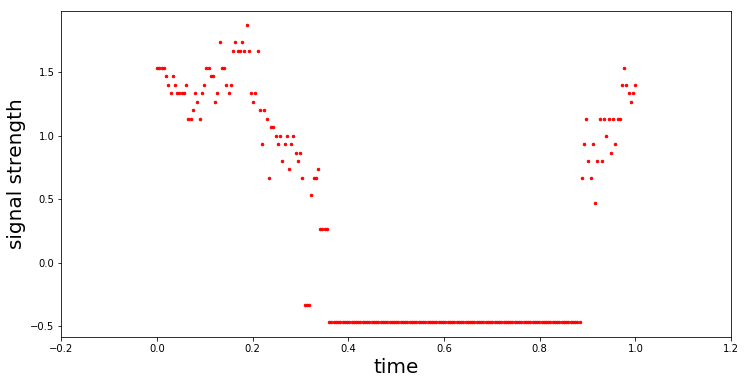

In [28]:
output_dim=1
xlim = (-0.3, 1.3)
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
_ = ax.plot(x.flatten(), y[:, output_dim], 
            'r.', markersize=5)

ax.set_xlabel('time', fontsize=20)
ax.set_ylabel('signal strength', fontsize=20)
xlim = (-0.2, 1.2)
ax.set_xlim(xlim)
ylim = ax.get_ylim()

mlai.write_figure(figure=fig, filename='../../slides/diagrams/datasets/robot-wireless-dim-' + str(output_dim) + '.svg', 
            transparent=True, frameon=True)

Perform a Gaussian process fit on the data using GPy.

In [29]:
m_full = GPy.models.GPRegression(x,yhat)
_ = m_full.optimize() # Optimize parameters of covariance function


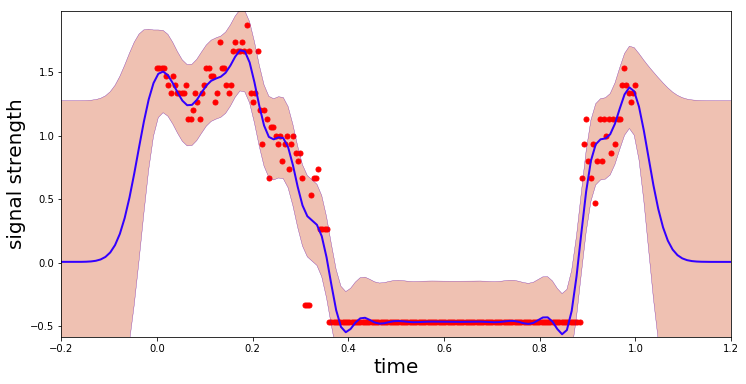

In [30]:
fig, ax=plt.subplots(figsize=plot.big_wide_figsize)
plot_model_output(m_full, output_dim=output_dim, scale=scale, offset=offset, ax=ax, xlabel='time', 
                  ylabel='signal strength', fontsize=20, portion=0.5)
ax.set_ylim(ylim)
ax.set_xlim(xlim)
mlai.write_figure(filename='../../slides/diagrams/deepgp/robot-wireless-gp-dim-' + str(output_dim)+ '.svg', 
            transparent=True, frameon=True)

In [31]:
layers = [y.shape[1], 10, 5, 2, 2, x.shape[1]]
inits = ['PCA']*(len(layers)-1)
kernels = []
for i in layers[1:]:
    kernels += [GPy.kern.RBF(i, ARD=True)]

In [32]:
m = deepgp.DeepGP(layers,Y=y, X=x, inits=inits, 
                  kernels=kernels,
                  num_inducing=50, back_constraint=False)
m.initialize()
m.staged_optimize(messages=(True,True,True))

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s14  0000   8.154847e+04           nan 
    02s33  0016   9.286466e+03   2.559590e+05 
    05s57  0038   1.925929e+03   1.037242e+05 
    07s68  0052   6.768799e+02   4.078614e+04 
    09s81  0067   2.212041e+02   1.356468e+05 
    10s93  0076   7.147963e+01   1.114903e+04 
    37s00  0233  -5.860179e+02   1.555479e+03 
    43s54  0271  -6.730710e+02   4.353547e+03 
 01m41s41  0586  -9.738429e+02   6.356706e+02 
 02m53s93  1002  -1.021465e+03   2.817408e+01 
Runtime:  02m53s93
Optimization status: Maximum number of f evaluations reached

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s15  0000  -1.021465e+03   2.817408e+01 
    02s26  0016  -1.113684e+03   1.337701e+03 
    10s96  0060  -1.183040e+03   4.345979e+03 
    32s09  0177  -1.299143e+03   2.121274e+02 
 01m37s07  0503  -1.340647e+03   1.961942e+01 
 03m15s44  1002  -1.355156e+03 

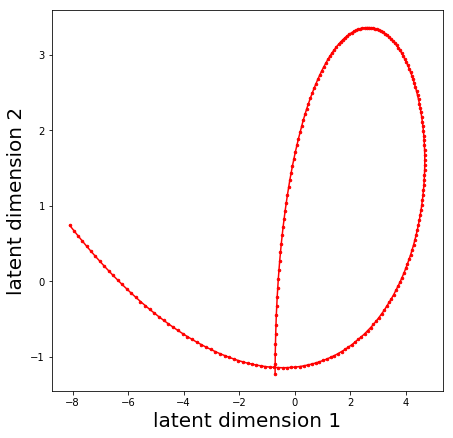

In [33]:
fig, ax = plt.subplots(figsize=plot.big_figsize)
ax.plot(m.layers[-2].latent_space.mean[:, 0], 
        m.layers[-2].latent_space.mean[:, 1], 
        'r.-', markersize=5)

ax.set_xlabel('latent dimension 1', fontsize=20)
ax.set_ylabel('latent dimension 2', fontsize=20)

mlai.write_figure(figure=fig, filename='../../slides/diagrams/deepgp/robot-wireless-latent-space.svg', 
            transparent=True, frameon=True)

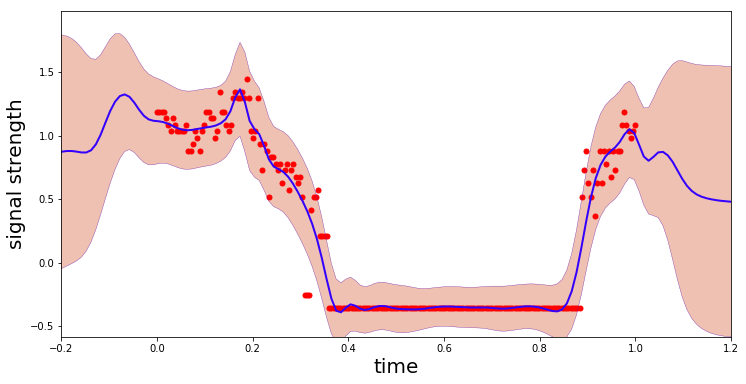

In [34]:
fig, ax=plt.subplots(figsize=plot.big_wide_figsize)
plot_model_output(m, output_dim=output_dim, scale=scale, offset=offset, ax=ax, xlabel='time', ylabel='signal strength', fontsize=20, portion=0.5)
ax.set_ylim(ylim)
ax.set_xlim(xlim)
mlai.write_figure(filename='../../slides/diagrams/deepgp/robot-wireless-deep-gp-dim-' + str(output_dim)+ '.svg', 
            transparent=True, frameon=True)

 /Users/neil/anaconda3/lib/python3.6/site-packages/GPy/core/gp.py:557: RuntimeWarning:covariance is not positive-semidefinite.


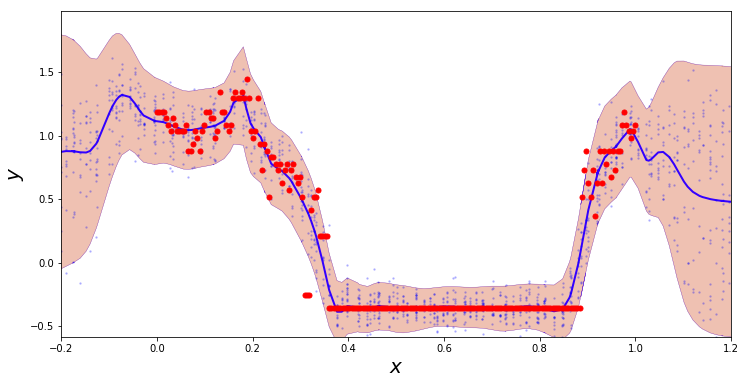

In [35]:
fig, ax=plt.subplots(figsize=plot.big_wide_figsize)
plot_model_sample(m, output_dim=output_dim, scale=scale, offset=offset, samps=10, ax=ax, portion = 0.5)
ax.set_ylim(ylim)
ax.set_xlim(xlim)
mlai.write_figure(figure=fig, filename='../../slides/diagrams/deepgp/robot-wireless-deep-gp-sample-dim-' + str(output_dim)+ '.svg', 
                  transparent=True, frameon=True)

# Step Function

Finally, we consider a simple step function data set. 

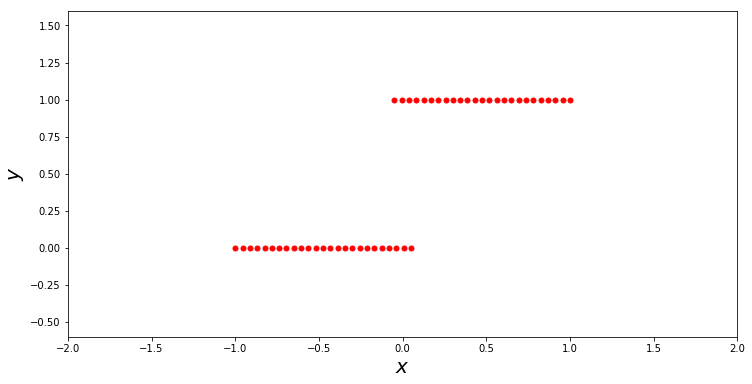

In [36]:
num_low=25
num_high=25
gap = -.1
noise=0.0001
x = np.vstack((np.linspace(-1, -gap/2.0, num_low)[:, np.newaxis],
              np.linspace(gap/2.0, 1, num_high)[:, np.newaxis]))
y = np.vstack((np.zeros((num_low, 1)), np.ones((num_high,1))))
scale = np.sqrt(y.var())
offset = y.mean()
yhat = (y-offset)/scale

fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
_ = ax.plot(x, y, 'r.',markersize=10)
_ = ax.set_xlabel('$x$', fontsize=20)
_ = ax.set_ylabel('$y$', fontsize=20)
xlim = (-2, 2)
ylim = (-0.6, 1.6)
ax.set_ylim(ylim)
ax.set_xlim(xlim)
mlai.write_figure(figure=fig, filename='../../slides/diagrams/datasets/step-function.svg', 
            transparent=True, frameon=True)

In [37]:
m_full = GPy.models.GPRegression(x,yhat)
_ = m_full.optimize() # Optimize parameters of covariance function

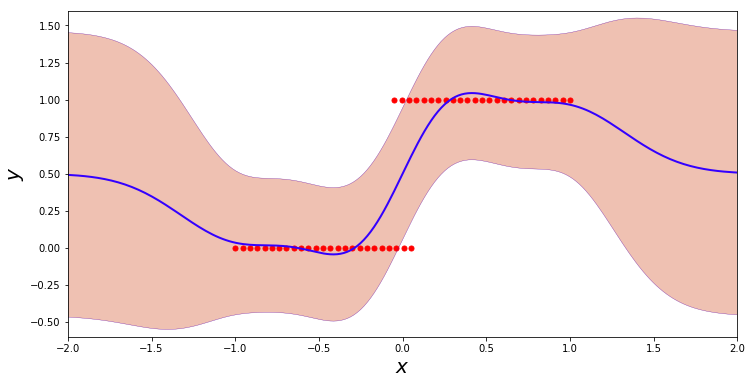

In [38]:
fig, ax=plt.subplots(figsize=plot.big_wide_figsize)
plot_model_output(m_full, scale=scale, offset=offset, ax=ax, fontsize=20, portion=0.5)
ax.set_ylim(ylim)
ax.set_xlim(xlim)

mlai.write_figure(figure=fig,filename='../../slides/diagrams/gp/step-function-gp.svg', 
            transparent=True, frameon=True)

In [39]:
layers = [y.shape[1], 1,x.shape[1]]
inits = ['PCA']*(len(layers)-1)
kernels = []
for i in layers[1:]:
    kernels += [GPy.kern.RBF(i)]
m = deepgp.DeepGP(layers,Y=yhat, X=x, 
                  inits=inits, 
                  kernels=kernels, # the kernels for each layer
                  num_inducing=20, back_constraint=False)

In [40]:
m.initialize()

In [41]:
m.staged_optimize()

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i       f              |g|        
    00s16  00007  -3.378771e+01   4.501974e+05 
    00s18  00008  -7.303996e+01   1.955102e+04 
    03s21  00197  -1.658031e+02   6.410632e-01 
    05s46  00337  -1.659280e+02   1.318525e-01 
Runtime:     05s46
Optimization status: Errorb'ABNORMAL_TERMINATION_IN_LNSRCH'



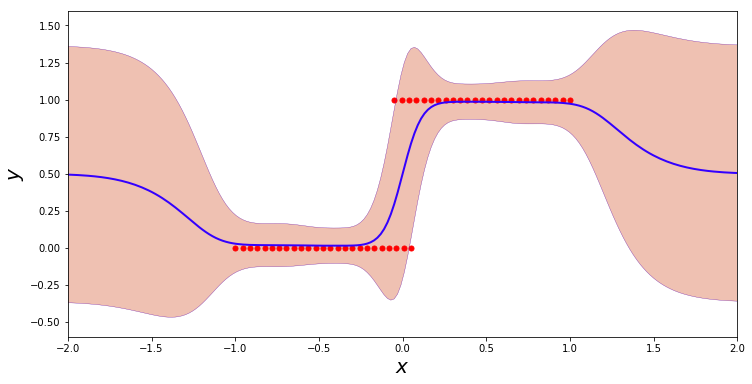

In [42]:
fig, ax=plt.subplots(figsize=plot.big_wide_figsize)
plot_model_output(m, scale=scale, offset=offset, ax=ax, fontsize=20, portion=0.5)
ax.set_ylim(ylim)
ax.set_xlim(xlim)
mlai.write_figure(filename='../../slides/diagrams/deepgp/step-function-deep-gp.svg', 
            transparent=True, frameon=True)

 /Users/neil/anaconda3/lib/python3.6/site-packages/GPy/core/gp.py:557: RuntimeWarning:covariance is not positive-semidefinite.


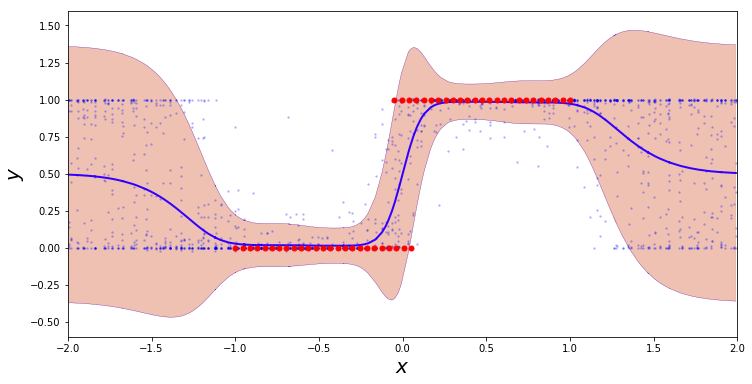

In [43]:
fig, ax=plt.subplots(figsize=plot.big_wide_figsize)
plot_model_sample(m, scale=scale, offset=offset, samps=10, ax=ax, portion = 0.5)
ax.set_ylim(ylim)
ax.set_xlim(xlim)
mlai.write_figure(figure=fig, filename='../../slides/diagrams/deepgp/step-function-deep-gp-sample.svg', 
                  transparent=True, frameon=True)

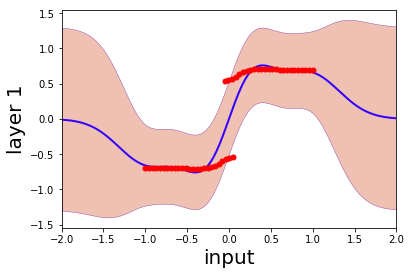

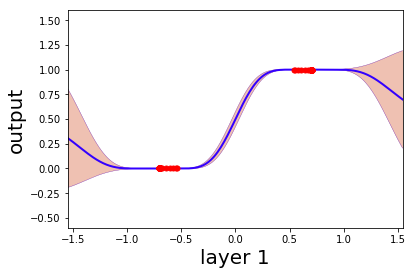

In [44]:
m.visualize(offset=offset, scale=scale, xlim=xlim, ylim=ylim,
            dataset='step-function',
            diagrams='../../slides/diagrams/deepgp')